In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers import Adam

plt.style.use(["science","bright","grid"])
folder  = "~/bagheera/data/1_funding_period/phase_space_sample/"

### Surrogate Model Data

In [3]:
df  = pd.read_csv(f"{folder}Nx=9_Ny=9_Ne=8.csv")
df

,E0,E1,E2,E3,E4,E5,E6,E7,G,Eq_Jumps,Jumps,Observable,Error
0,0.01182,-0.00646,0.07780,-0.01338,-0.01870,-0.05314,-0.09545,0.0,0.0,100000.0,75000.0,-4.298110e+08,1.768656e+07
1,-0.01482,-0.04694,-0.02325,-0.04860,-0.05950,0.02327,0.08376,0.0,0.0,100000.0,185000.0,1.285388e+08,6.037295e+06
2,-0.05274,0.04227,-0.09091,-0.01855,0.00589,0.05421,-0.00289,0.0,0.0,100000.0,515000.0,5.635003e+07,2.693918e+06
3,0.00213,-0.00459,-0.01814,0.09199,-0.02235,0.06526,-0.00573,0.0,0.0,100000.0,125000.0,2.316145e+08,9.511503e+06
4,-0.01126,0.07502,0.07540,-0.02272,0.01470,-0.09880,-0.02350,0.0,0.0,100000.0,145000.0,-2.098581e+08,9.860593e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...
137395,-0.01044,0.03704,-0.03002,0.00893,-0.03717,0.01733,-0.06402,0.0,0.0,100000.0,130000.0,-1.588399e+08,6.940426e+06
137396,0.08818,0.02557,0.04168,0.09006,-0.02829,0.07461,0.06325,0.0,0.0,100000.0,30000.0,6.154428e+08,2.102978e+07
137397,-0.00178,-0.07585,-0.02368,0.02695,0.02732,0.06724,0.06927,0.0,0.0,100000.0,90000.0,3.538512e+08,1.400818e+07
137398,-0.05323,-0.09070,0.03017,0.06784,-0.08455,-0.01796,0.08625,0.0,0.0,100000.0,390000.0,9.572638e+07,4.545721e+06


### Prepare and Split Data

In [5]:
X       = df.iloc[:,:8].values
X       = 2 * (X - X.min()) / (X.max() - X.min()) - 1
y       = df['Observable'].values
y_min   = y.min()
y_max   = y.max()
y       = 2 * (y - y.min()) / (y.max() - y.min()) - 1

X_train, X_test, y_train, y_test    = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val      = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [6]:
len(X_train)

98928

### Define Model

In [7]:
# model = Sequential()
# model.add(Dense(64, input_dim=8, activation='tanh'))    # First hidden layer
# model.add(Dense(32, activation='tanh'))                 # Second hidden layer
# model.add(Dense(1, activation='linear'))                # Output layer

model = Sequential()
model.add(Dense(64, input_dim=8))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(32))
model.add(LeakyReLU(alpha=0.01))
model.add(Dense(1, activation='linear'))

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',                                 # Monitor validation loss
    patience=10,                                        # Stop after 10 epochs without improvement
    restore_best_weights=True                           # Restore the best model weights
)

/home/jonasmensing/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1757451245.564947    4577 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/jonasmensing/.local/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [17]:
# Compile model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=1000, batch_size=256, callbacks=[early_stopping])

Epoch 1/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.7255e-04 - val_loss: 1.7419e-04
Epoch 2/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7166e-04 - val_loss: 1.7285e-04
Epoch 3/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7051e-04 - val_loss: 1.7148e-04
Epoch 4/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.7025e-04 - val_loss: 1.7008e-04
Epoch 5/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6750e-04 - val_loss: 1.6903e-04
Epoch 6/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6671e-04 - val_loss: 1.6827e-04
Epoch 7/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6580e-04 - val_loss: 1.6650e-04
Epoch 8/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6495e-04 - val_loss: 1.6548e-04
Epoch 9/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6360e-04 - val_loss: 1.6466e-04
Epoch 10/1000
387/387 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.6325e-04 - val_loss: 1.6327e-04
Epoch 11/1000
387/387 ━━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [18]:
# Evaluate model
loss            = model.evaluate(X_test, y_test)                    # Loss in scaled units
predictions     = model.predict(X_test)
predictions     = (predictions + 1) * (y_max - y_min) / 2 + y_min   # Unscale predictions
y_test_unscaled = (y_test + 1) * (y_max - y_min) / 2 + y_min        # Unscale y_test

# Calculate RMSE in pA
rmse = np.sqrt(mean_squared_error(y_test_unscaled, predictions))
print(f"RMSE: {rmse} pA")

859/859 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step - loss: 6.9684e-05
859/859 ━━━━━━━━━━━━━━━━━━━━ 1s 640us/step
RMSE: 8613233.243610157 pA


In [19]:
# Unscale training and validation loss
train_loss_unscaled = np.sqrt(np.array(history.history['loss'])) * (y_max - y_min) / 2
val_loss_unscaled   = np.sqrt(np.array(history.history['val_loss'])) * (y_max - y_min) / 2
residuals           = y_test_unscaled - predictions.flatten()

In [20]:
predictions.flatten()

array([ 3.3678701e+08, -1.9764371e+08, -1.0403584e+07, ...,
        6.2436160e+07,  4.9462317e+08, -1.5430080e+07], dtype=float32)

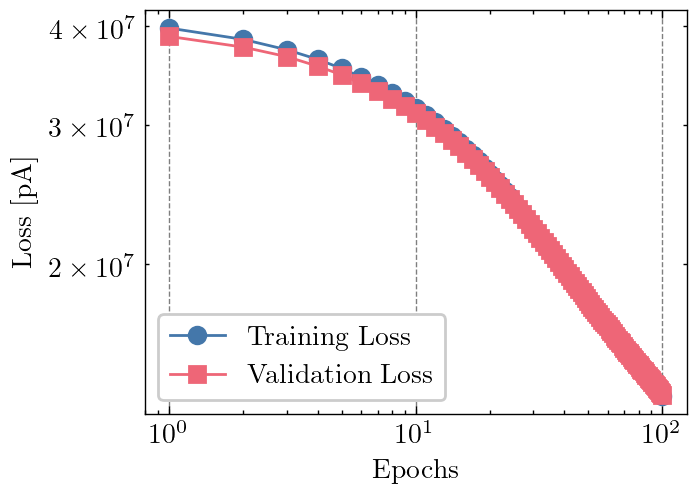

In [21]:
train_loss  = history.history['loss']
val_loss    = history.history['val_loss']
epochs      = range(1, len(train_loss) + 1)

fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.plot(range(1,len(train_loss_unscaled)+1), train_loss_unscaled, '-o', label='Training Loss')
ax.plot(range(1,len(val_loss_unscaled)+1), val_loss_unscaled, '-s', label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss [pA]')
ax.legend()
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(10,1000)
# ax.set_yscale('log')

Text(0, 0.5, 'Predicted Values [pA]')

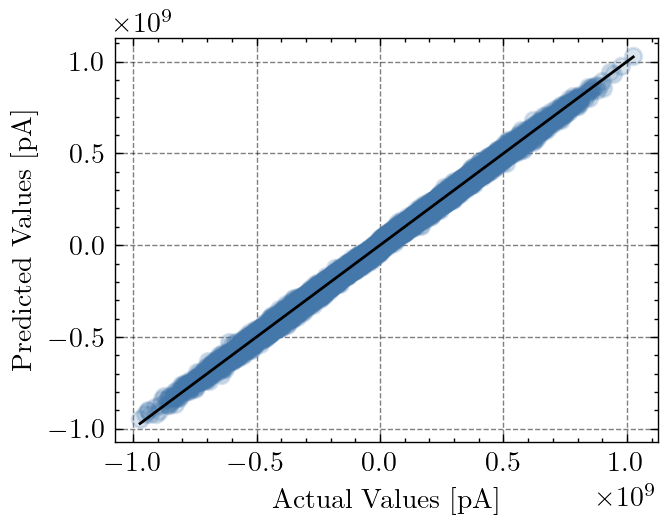

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.scatter(y_test_unscaled, predictions, alpha=0.2)
ax.plot([y_test_unscaled.min(), y_test_unscaled.max()], [y_test_unscaled.min(), y_test_unscaled.max()], color='black')
ax.set_xlabel('Actual Values [pA]')
ax.set_ylabel('Predicted Values [pA]')

Text(0, 0.5, 'Residuals')

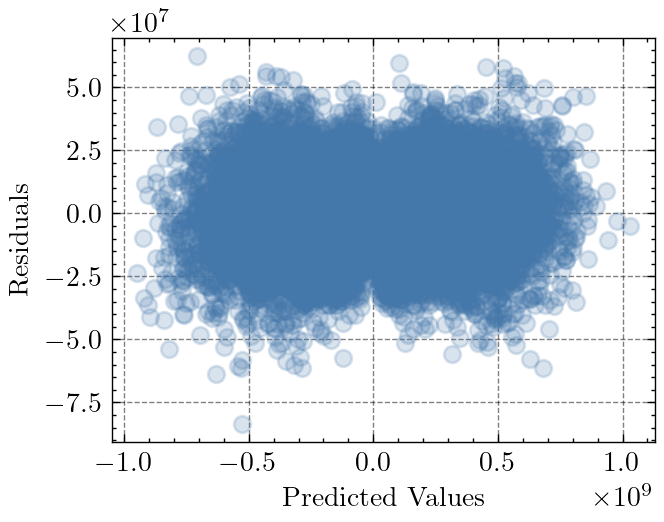

In [ ]:
fig = plt.figure(dpi=200)
ax  = fig.add_subplot()
ax.scatter(predictions.flatten(), residuals, alpha=0.2)
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Residuals')